In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV

c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\xgboost\__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [2]:
public_vacation_list = [
    '20170102', '20170128', '20170130', '20170131', '20170404',
    '20170414', '20170415', '20170417', '20170501', '20170503',
    '20170530', '20170701', '20171002', '20171005', '20171028',
    '20171225', '20171226', '20180101', '20180216', '20180217',
    '20180219', '20180330', '20180331', '20180402', '20180405',
    '20180501', '20180522', '20180618', '20180702', '20180925',
    '20181001', '20181017', '20181225', '20181226'
]

In [3]:
rain_day = [
    '20180106', '20180107', '20180108', '20180109', '20180131',
    '20180222', '20180223', '20180224', '20180308', '20180314',
    '20180415', '20180416', '20180424', '20180503', '20180506',
    '20180507', '20180508', '20180509', '20180510', '20180604', 
    '20180605', '20180606', '20180607', '20180608', '20180609',  
    '20180612', '20180613', '20180622', '20180623', '20180624',  
    '20180625', '20180701', '20180703', '20180704', '20180706',
    '20180707', '20180708', '20180709', '20180713', '20180714',
    '20180715', '20180716', '20180717', '20180718', '20180719',
    '20180720', '20180723', '20180802', '20180804', '20180810',
    '20180811', '20180812', '20180814', '20180817', '20180818',
    '20180819', '20180820', '20180821', '20180822', '20180823',
    '20180826', '20180827', '20180828', '20180829', '20180830',
    '20180831', '20180901', '20180902', '20180908', '20180909',
    '20180916', '20180917', '20180924', '20180925', '20180926',
    '20181001', '20181008', '20181010', '20181015', '20181016',
    '20181018', '20181103', '20181116', '20181121', '20181125',
    '20181126', '20181127', '20181128', '20181207', '20181223',
    '20170113', '20170114', '20170115', '20170116', '20170128',
    '20170129', '20170130', '20170131', '20170204', '20170205',
    '20170221', '20170222', '20170225', '20170226', '20170308',
    '20170314', '20170319', '20170331', '20170412', '20170420',
    '20170421', '20170422', '20170425', '20170426', '20170427',
    '20170504', '20170515', '20170524', '20170612', '20170613',
    '20170614', '20170615', '20170616', '20170617', '20170618',
    '20170619', '20170620', '20170621', '20170624', '20170701',
    '20170702', '20170703', '20170704', '20170705', '20170706',
    '20170707', '20170708', '20170715', '20170716', '20170717',
    '20170718', '20170719', '20170723', '20170801', '20170802',
    '20170803', '20170804', '20170807', '20170809', '20170810',
    '20170823', '20170827', '20170828', '20170901', '20170903',
    '20170904', '20170905', '20170909', '20170922', '20170923', 
    '20170924', '20170930', '20171001', '20171002', '20171004',
    '20171015', '20171016', '20171017', '20171112', '20171113',
    '20171118', '20171119',
]

In [4]:
heavy_rain_day= ['20170524', '20170613', '20170617','20170717','20170803','20180608','20180826','20180827',
                 '20180829', '20180916',]

In [5]:
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")

In [6]:
def preprocess_data(data):
    data_of_date = data['date'].tolist()
    date = []
    time = []
    for row in data_of_date:
        temp = row.split(" ")
        date.append(temp[0])
        time.append(int(temp[1].split(':')[0]))
    data['date'] = pd.to_datetime(date,format="%d/%m/%Y")
    data['time'] = time
    return data['date'],data['time']

In [7]:
training_data['date'],training_data['time'] = preprocess_data(training_data)
training_data['year'] = training_data['date'].dt.year
training_data['quarter'] = training_data['date'].dt.quarter
training_data['month'] = training_data['date'].dt.month
training_data['day'] = training_data['date'].dt.day
training_data['dayofweek'] = training_data['date'].dt.dayofweek
training_data['dayofyear'] = training_data['date'].dt.dayofyear
training_data['weekofyear'] = training_data['date'].dt.week
training_data['date'] = training_data['date'].apply(lambda x: x.strftime('%Y%m%d'))
training_data['is_public_holiday'] = training_data['date'].apply(lambda x: 1 if x in public_vacation_list else 0)
training_data['is_rainy_day'] = training_data['date'].apply(lambda x: 1 if x in rain_day else 0)
training_data['time_1'] = training_data['time'].apply(lambda x: 1 if 0 <= x <= 7 else 0)
training_data['time_2'] = training_data['time'].apply(lambda x: 1 if 8 <= x <= 9 or  12 <= x <= 16 else 0)
training_data['time_3'] = training_data['time'].apply(lambda x: 1 if 10 <= x <= 11 or x == 19 else 0)
training_data['time_4'] = training_data['time'].apply(lambda x: 1 if 17 <= x <= 18 else 0)
training_data['time_5'] = training_data['time'].apply(lambda x: 1 if 20 <= x <= 23 else 0)

In [8]:
training_data

,id,date,speed,time,year,quarter,month,day,dayofweek,dayofyear,weekofyear,is_public_holiday,is_rainy_day,time_1,time_2,time_3,time_4,time_5
0,0,20170101,43.002930,0,2017,1,1,1,6,1,52,0,0,1,0,0,0,0
1,1,20170101,46.118696,1,2017,1,1,1,6,1,52,0,0,1,0,0,0,0
2,2,20170101,44.294158,2,2017,1,1,1,6,1,52,0,0,1,0,0,0,0
3,3,20170101,41.067468,3,2017,1,1,1,6,1,52,0,0,1,0,0,0,0
4,4,20170101,46.448653,4,2017,1,1,1,6,1,52,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,14001,20181231,19.865269,12,2018,4,12,31,0,365,1,0,0,0,1,0,0,0
14002,14002,20181231,17.820375,15,2018,4,12,31,0,365,1,0,0,0,1,0,0,0
14003,14003,20181231,12.501851,16,2018,4,12,31,0,365,1,0,0,0,1,0,0,0
14004,14004,20181231,15.979319,18,2018,4,12,31,0,365,1,0,0,0,0,0,1,0


In [9]:
testing_data['date'],testing_data['time'] = preprocess_data(testing_data)
testing_data['year'] = testing_data['date'].dt.year
testing_data['quarter'] = testing_data['date'].dt.quarter
testing_data['month'] = testing_data['date'].dt.month
testing_data['day'] = testing_data['date'].dt.day
testing_data['dayofweek'] = testing_data['date'].dt.dayofweek
testing_data['dayofyear'] = testing_data['date'].dt.dayofyear
testing_data['weekofyear'] = testing_data['date'].dt.week
testing_data['date'] = testing_data['date'].apply(lambda x: x.strftime('%Y%m%d'))
testing_data['is_public_holiday'] = testing_data['date'].apply(lambda x: 1 if x in public_vacation_list else 0)
testing_data['is_rainy_day'] = testing_data['date'].apply(lambda x: 1 if x in rain_day else 0)
testing_data['time_1'] = testing_data['time'].apply(lambda x: 1 if 0 <= x <= 7 else 0)
testing_data['time_2'] = testing_data['time'].apply(lambda x: 1 if 8 <= x <= 9 or  12 <= x <= 16 else 0)
testing_data['time_3'] = testing_data['time'].apply(lambda x: 1 if 10 <= x <= 11 or x == 19 else 0)
testing_data['time_4'] = testing_data['time'].apply(lambda x: 1 if 17 <= x <= 18 else 0)
testing_data['time_5'] = testing_data['time'].apply(lambda x: 1 if 20 <= x <= 23 else 0)

In [10]:
testing_data

,id,date,time,year,quarter,month,day,dayofweek,dayofyear,weekofyear,is_public_holiday,is_rainy_day,time_1,time_2,time_3,time_4,time_5
0,0,20180101,2,2018,1,1,1,0,1,1,1,0,1,0,0,0,0
1,1,20180101,5,2018,1,1,1,0,1,1,1,0,1,0,0,0,0
2,2,20180101,7,2018,1,1,1,0,1,1,1,0,1,0,0,0,0
3,3,20180101,8,2018,1,1,1,0,1,1,1,0,0,1,0,0,0
4,4,20180101,10,2018,1,1,1,0,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,3499,20181231,17,2018,4,12,31,0,365,1,0,0,0,0,0,1,0
3500,3500,20181231,19,2018,4,12,31,0,365,1,0,0,0,0,1,0,0
3501,3501,20181231,21,2018,4,12,31,0,365,1,0,0,0,0,0,0,1
3502,3502,20181231,22,2018,4,12,31,0,365,1,0,0,0,0,0,0,1


In [11]:
x_train = training_data.drop(["speed","date","id"], axis=1)
y_train = training_data["speed"]
x_test = testing_data.drop(["date","id"], axis=1)

In [12]:
print(x_train)
print(y_train)
print(x_test)

       time  year  quarter  month  day  dayofweek  dayofyear  weekofyear  \
0         0  2017        1      1    1          6          1          52   
1         1  2017        1      1    1          6          1          52   
2         2  2017        1      1    1          6          1          52   
3         3  2017        1      1    1          6          1          52   
4         4  2017        1      1    1          6          1          52   
...     ...   ...      ...    ...  ...        ...        ...         ...   
14001    12  2018        4     12   31          0        365           1   
14002    15  2018        4     12   31          0        365           1   
14003    16  2018        4     12   31          0        365           1   
14004    18  2018        4     12   31          0        365           1   
14005    20  2018        4     12   31          0        365           1   

       is_public_holiday  is_rainy_day  time_1  time_2  time_3  time_4  time_5  
0     

In [13]:
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train,test_size=0.2)

cv_params = {}
other_params = {'learning_rate': 0.03, 'n_estimators': 310, 'max_depth': 24, 'min_child_weight': 2, 'seed': 0,
               'subsample': 0.94, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 9, 'reg_lambda': 5}

model = xgb.XGBRegressor(**other_params)

optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs = 4)

optimized_GBM.fit(xx_train, yy_train)
yy_pred = optimized_GBM.predict(xx_test)

print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   33.4s finished


参数的最佳取值：{}
最佳模型得分:0.9414855933511348


In [14]:
def trainandtest(X_train, Y_train, X_test):
    XX_train, XX_test, YY_train, YY_test = train_test_split(X_train, Y_train,test_size = 0.2, random_state = 1)
        
    model = xgb.XGBRegressor(**other_params)
    model.fit(XX_train, YY_train)
    
    plot_importance(model)
    plt.show()

    valid_pred = model.predict(XX_test)
    print("MSE:", mean_squared_error(valid_pred,YY_test))

    # testing prediction
    pred = model.predict(X_test)
    
    pred_len = len(pred)
    pred_arr = []
    for i in range(0, pred_len):
        pred_arr.append([int(i), pred[i]])
    
    return pred_arr

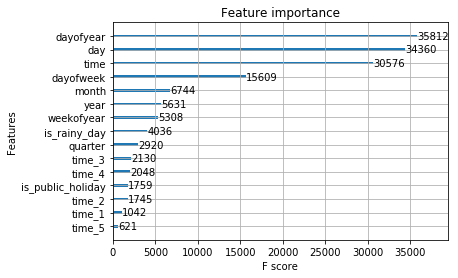

MSE: 10.629746826736879


In [15]:
result = trainandtest(x_train,y_train,x_test)

In [16]:
# write in csv
pd_data = pd.DataFrame(result, columns=['id', 'speed'])
pd_data.to_csv('submit.csv', index=None)

In [ ]:
# 10.62974